# 1. k-Nearest Neighbor classifier

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code!

In [1]:
%matplotlib inline

import random
import os
import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Get the Data

In [ ]:
!wget -P /tmp/cifar-10 -c http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar xvzf /tmp/cifar-10/cifar-10-python.tar.gz  -C /tmp/cifar-10
!rm /tmp/cifar-10/cifar-10-python.tar.gz

In [2]:
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

In [3]:
def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

We can now use the above methods to lead the data and as a sanity check, we print out the size of the training and test data.

In [6]:
cifar10_dir = '/home/min-joon/cifar-10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Explore the data

We show a few examples of training images from each label class.

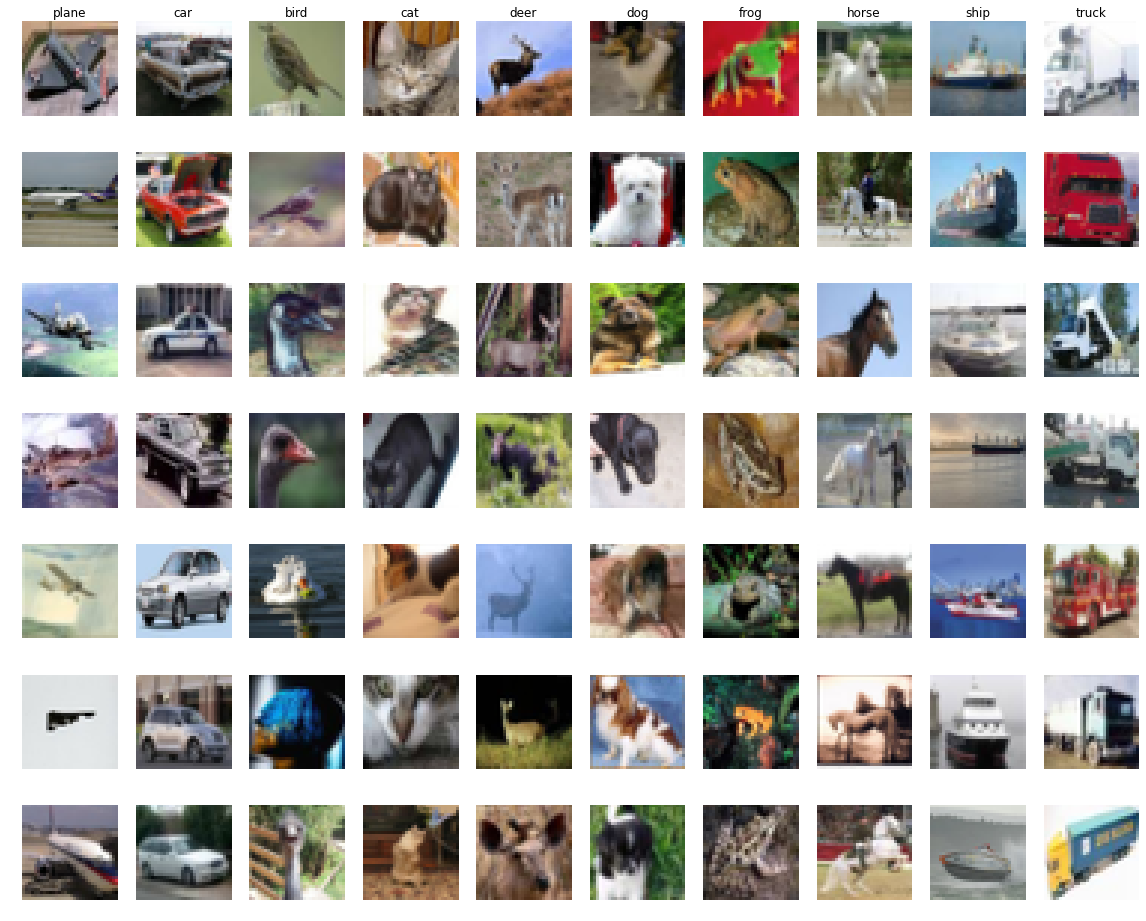

In [7]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Sub-Sampling

In order to speed up the execution of code in this exercise we will take a small sample of the original data:

In [8]:
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

## Reshape the data

In order to do the pixel comparison we reshape our RGB images into long vectors of pixels:

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(5000, 3072) (500, 3072)


# kNN classifier

Here we define the initial kNN classifier with L2 distance class:

In [10]:
class KNearestNeighbor:
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Input:
    X - A num_train x dimension array where each row is a training point.
    y - A vector of length num_train, where y[i] is the label for X[i, :]
    """
    self.X_train = X
    self.y_train = y
  
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Input:
    X - A num_test x dimension array where each row is a test point.
    k - The number of nearest neighbors that vote for predicted label
    num_loops - Determines which method to use to compute distances
                between training points and test points.

    Output:
    y - A vector of length num_test, where y[i] is the predicted label for the
        test point X[i, :].
    """
    if num_loops == 0:
        dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
        dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
        dists = self.compute_distances_two_loops(X)
    else:
        raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.

    Input:
    X - An num_test x dimension array where each row is a test point.

    Output:
    dists - A num_test x num_train array where dists[i, j] is the distance
            between the ith test point and the jth training point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
        for j in xrange(num_train):
            #####################################################################
            # TODO:                                                             #
            # Compute the l2 distance between the ith test point and the jth    #
            # training point, and store the result in dists[i, j]               #
            #####################################################################
            dists[i, j] = np.sum(np.square(self.X_train[j,:] - X[i,:]))
            #####################################################################
            #                       END OF YOUR CODE                            #
            #####################################################################
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
        #######################################################################
        # TODO:                                                               #
        # Compute the l2 distance between the ith test point and all training #
        # points, and store the result in dists[i, :].                        #
        #######################################################################
        dists[i, :] = np.sum(np.square(self.X_train - X[i,:]), axis=1)
        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    #########################################################################
    # TODO:                                                                 #
    # Compute the l2 distance between all test points and all training      #
    # points without using any explicit loops, and store the result in      #
    # dists.                                                                #
    # HINT: Try to formulate the l2 distance using matrix multiplication    #
    #       and two broadcast sums.                                         #
    ######################################################################### 
    
    #After expanding the square of the term
    
    I1square    = np.sum(np.square(X),axis=1,keepdims = True)
    minustwoI1I2 = np.multiply(np.dot(X, self.X_train.T),-2)
    I2square     = np.sum(np.square(self.X_train),axis=1)
    
    dists = np.add(minustwoI1I2, np.add(I1square,I2square))
    #########################################################################
    #                         END OF YOUR CODE                              #
    #########################################################################
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Input:
    dists - A num_test x num_train array where dists[i, j] gives the distance
            between the ith test point and the jth training point.

    Output:
    y - A vector of length num_test where y[i] is the predicted label for the
        ith test point.
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in xrange(num_test):
        # A list of length k storing the labels of the k nearest neighbors to
        # the ith test point.
        closest_y = []
        #########################################################################
        # TODO:                                                                 #
        # Use the distance matrix to find the k nearest neighbors of the ith    #
        # training point, and use self.y_train to find the labels of these      #
        # neighbors. Store these labels in closest_y.                           #
        # Hint: Look up the function numpy.argsort.                             #
        #########################################################################
        closest_y = self.y_train[np.argsort(dists[i, :])[:k]]
        #########################################################################
        # TODO:                                                                 #
        # Now that you have found the labels of the k nearest neighbors, you    #
        # need to find the most common label in the list closest_y of labels.   #
        # Store this label in y_pred[i]. Break ties by choosing the smaller     #
        # label.                                                                #
        #########################################################################
        y_pred[i] = np.argmax(np.bincount(closest_y))
        #########################################################################
        #                           END OF YOUR CODE                            # 
        #########################################################################

    return y_pred

Let us now create a kNN classifier instance and train it (which just remembers the data and does nothing else):

In [11]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

## Exercise 1

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

Implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [12]:
# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print dists.shape

(500, 5000)


We can visualize the distance matrix: each row is a single test example and its distances to training examples:

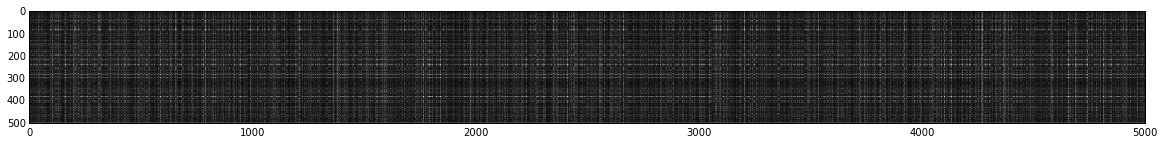

In [13]:
plt.imshow(dists, interpolation='none')

Notice the structured patterns in the distance matrix. 

- What is the cause behind the distinctly visible rows? 
- What causes the columns?

Your answer here.
A black row shows testdata, quite similar to all of the training data (more ambiguous)
A more white row shows a general high distance to all other training data (more unique)

Now implement the function `predict_labels()` and run the code below. We use `k = 1` (which is Nearest Neighbor).

In [14]:
y_test_pred = classifier.predict_labels(dists, k=1)

Let us compute and print the fraction of correctly predicted examples:

In [15]:
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


### One Loop

Now lets speed up distance matrix computation by using partial vectorization
with one loop. Implement the function `compute_distances_one_loop()` and run the
code below:

In [16]:
dists_one = classifier.compute_distances_one_loop(X_test)

To ensure that our vectorized implementation is correct, we make sure that it
agrees with the naive implementation. There are many ways to decide whether
two matrices are similar; one of the simplest is the Frobenius norm. In case
you haven't seen it before, the Frobenius norm of two matrices is the square
root of the squared sum of differences of all elements; in other words, `reshape`
the matrices into vectors and compute the Euclidean distance between them.

In [17]:
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
    print 'Good! The distance matrices are the same'
else:
    print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


### Vectorized

Now implement the fully vectorized version inside `compute_distances_no_loops()` and run the code:

In [18]:
dists_two = classifier.compute_distances_no_loops(X_test)

Let us check that the distance matrix agrees with the one we computed before:

In [19]:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
    print 'Good! The distance matrices are the same'
else:
    print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


Finally we can compare how fast these implementations are. You should see significantly faster performance with the fully vectorized implementation.

In [20]:
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

Two loop version took 63.086548 seconds
One loop version took 73.935057 seconds
No loop version took 12.836298 seconds


## Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 1 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [21]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}
for k in k_choices:   
    k_to_accuracies[k] = np.zeros(num_folds)



################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

for i in range(num_folds):
    train   = list(X_train_folds)
    val_set = train.pop(i)
    train = np.concatenate(train)

    label = list(y_train_folds)
    test_label = label.pop(i)
    label = np.concatenate(label)

    classifier.train(train, label)

    #y_test_pred = classifier.predict(val_set, k)
    dists = classifier.compute_distances_no_loops(val_set)
    for k in k_choices:        

        y_test_pred = classifier.predict_labels(dists, k)
        
        
        num_correct = np.sum(y_test_pred == test_label)
        accuracy = float(num_correct) / num_test
        k_to_accuracies[k][i] =  accuracy
    
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

k = 1, accuracy = 0.526000
k = 1, accuracy = 0.514000
k = 1, accuracy = 0.528000
k = 1, accuracy = 0.556000
k = 1, accuracy = 0.532000
k = 3, accuracy = 0.478000
k = 3, accuracy = 0.498000
k = 3, accuracy = 0.480000
k = 3, accuracy = 0.532000
k = 3, accuracy = 0.508000
k = 5, accuracy = 0.496000
k = 5, accuracy = 0.532000
k = 5, accuracy = 0.560000
k = 5, accuracy = 0.584000
k = 5, accuracy = 0.560000
k = 8, accuracy = 0.524000
k = 8, accuracy = 0.564000
k = 8, accuracy = 0.546000
k = 8, accuracy = 0.580000
k = 8, accuracy = 0.546000
k = 10, accuracy = 0.530000
k = 10, accuracy = 0.592000
k = 10, accuracy = 0.552000
k = 10, accuracy = 0.568000
k = 10, accuracy = 0.560000
k = 12, accuracy = 0.520000
k = 12, accuracy = 0.590000
k = 12, accuracy = 0.558000
k = 12, accuracy = 0.566000
k = 12, accuracy = 0.560000
k = 15, accuracy = 0.504000
k = 15, accuracy = 0.578000
k = 15, accuracy = 0.556000
k = 15, accuracy = 0.564000
k = 15, accuracy = 0.548000
k = 20, accuracy = 0.540000
k = 20, accu

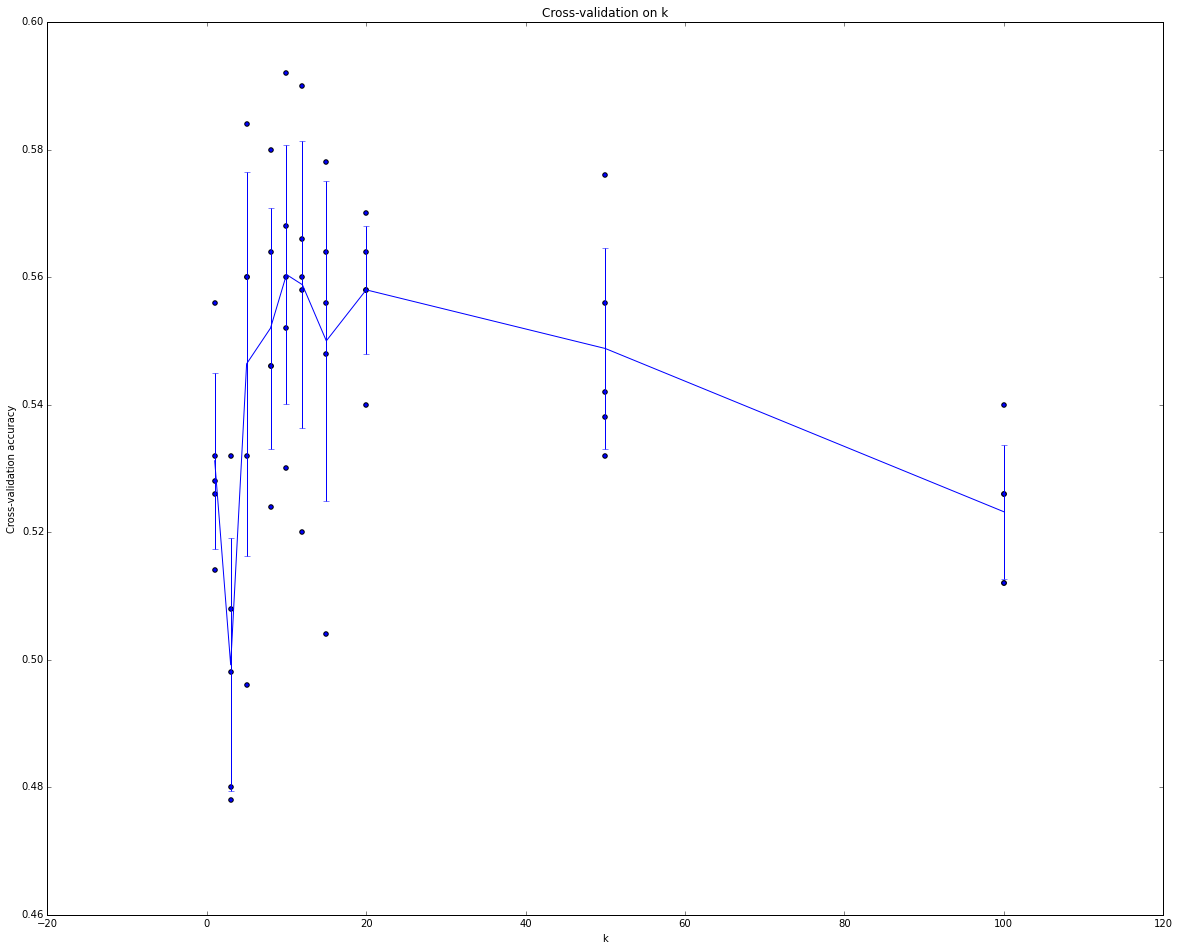

In [22]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [23]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data.
best_k = 10 

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 141 / 500 correct => accuracy: 0.282000
